# Tutorial 1: Training and Evaluation of Logistic Regression on Encrypted Data

Welcome to this first use case tutorial, where we are going to show how to use TenSEAL for training and evaluating a logistic regression (LR) model on encrypted data (using homomorphic encryption) for heart disease prediction! If you haven't played with TenSEAL before, or need a quick overview of what homomorphic encryption is, I would suggest going through ['Tutorial 0 - Getting Started'](./Tutorial%200%20-%20Getting%20Started.ipynb) first.


**Important note:** The goal of this tutorial isn't to show how efficient logistic regression is for this task, we will just go with whatever accuracy we get, but the training and evaluation on encrypted data should be comparable to when we use plain data.


Authors:
- Ayoub Benaissa - Twitter: [@y0uben11](https://twitter.com/y0uben11)

## Setup

All modules are imported here, make sure everything is installed by running the cell below

In [1]:
import torch
import tenseal as ts
import pandas as pd
import random
from time import time

# those are optional and are not necessary for training
import numpy as np
import matplotlib.pyplot as plt

We now prepare the training and test data, the dataset was downloaded from Kaggle [here](https://www.kaggle.com/dileep070/heart-disease-prediction-using-logistic-regression), this dataset provides patients' information along with a 10-year risk of future coronary heart disease (CHD) as a label, and the goal is to build a model that can predict this 10-year CHD risk from patients' information, you can read more about the dataset in the link provided. We also provide this `random_data()` generator for those who just want to see how things work, you can just plug that one and the rest of the tutorial should work the same way.

In [2]:
torch.random.manual_seed(73)
random.seed(73)


def split_train_test(x, y, test_ratio=0.3):
    idxs = [i for i in range(len(x))]
    random.shuffle(idxs)
    # delimiter between test and train data
    delim = int(len(x) * test_ratio)
    test_idxs, train_idxs = idxs[:delim], idxs[delim:]
    return x[train_idxs], y[train_idxs], x[test_idxs], y[test_idxs]


def heart_disease_data():
    data = pd.read_csv("./data/framingham.csv")
    # drop rows with missing values
    data = data.dropna()
    # drop some features
    data = data.drop(columns=["education", "currentSmoker", "BPMeds", "diabetes", "diaBP", "BMI"])
    # balance data
    grouped = data.groupby('TenYearCHD')
    data = grouped.apply(lambda x: x.sample(grouped.size().min(), random_state=73).reset_index(drop=True))
    # extract labels
    y = torch.tensor(data["TenYearCHD"].values).float().unsqueeze(1)
    data = data.drop("TenYearCHD", 'columns')
    # normalize data
    data = (data - data.mean()) / data.std()
    x = torch.tensor(data.values).float()
    return split_train_test(x, y)


def random_data(m=1024, n=2):
    # data separable by the line `y = x`
    x_train = torch.randn(m, n)
    x_test = torch.randn(m // 2, n)
    y_train = (x_train[:, 0] >= x_train[:, 1]).float().unsqueeze(0).t()
    y_test = (x_test[:, 0] >= x_test[:, 1]).float().unsqueeze(0).t()
    return x_train, y_train, x_test, y_test


# You can use whatever data you want without modification to the tutorial
# x_train, y_train, x_test, y_test = random_data()
x_train, y_train, x_test, y_test = heart_disease_data()

print("############# Data summary #############")
print(f"x_train has shape: {x_train.shape}")
print(f"y_train has shape: {y_train.shape}")
print(f"x_test has shape: {x_test.shape}")
print(f"y_test has shape: {y_test.shape}")
print("#######################################")

############# Data summary #############
x_train has shape: torch.Size([780, 9])
y_train has shape: torch.Size([780, 1])
x_test has shape: torch.Size([334, 9])
y_test has shape: torch.Size([334, 1])
#######################################


## Training a Logistic Regression Model

We will start by training a logistic regression model (without any encryption), which can be viewed as a single layer neural network with a single node. We will be using this model as a mean of comparison against encrypted training and evaluation.

In [3]:
class LR(torch.nn.Module):

    def __init__(self, n_features):
        super(LR, self).__init__()
        self.lr = torch.nn.Linear(n_features, 1)
        
    def forward(self, x):
        out = torch.sigmoid(self.lr(x))
        return out

In [4]:
n_features = x_train.shape[1]
model = LR(n_features)
# use gradient descent with a learning_rate=1
optim = torch.optim.SGD(model.parameters(), lr=1)
# use Binary Cross Entropy Loss
criterion = torch.nn.BCELoss()

In [5]:
# define the number of epochs for both plain and encrypted training
EPOCHS = 10

def train(model, optim, criterion, x, y, epochs=EPOCHS):
    for e in range(1, epochs + 1):
        optim.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optim.step()
        print(f"Loss at epoch {e}: {loss.data}")
    return model

model = train(model, optim, criterion, x_train, y_train)

Loss at epoch 1: 0.8504332900047302
Loss at epoch 2: 0.6863385438919067
Loss at epoch 3: 0.635811448097229
Loss at epoch 4: 0.6193529367446899
Loss at epoch 5: 0.6124349236488342
Loss at epoch 6: 0.6089245080947876
Loss at epoch 7: 0.6069258451461792
Loss at epoch 8: 0.6057038307189941
Loss at epoch 9: 0.6049202084541321
Loss at epoch 10: 0.6043994426727295


In [6]:
def accuracy(model, x, y):
    out = model(x)
    correct = torch.abs(y - out) < 0.5
    return correct.float().mean()

plain_accuracy = accuracy(model, x_test, y_test)
print(f"Accuracy on plain test_set: {plain_accuracy}")

Accuracy on plain test_set: 0.697604775428772


It is worth reminding that a high accuracy isn't our goal, we just want to see that training on encrypted data doesn't affect the final result, so we will be comparing accuracies over encrypted data against the `plain_accuracy` we got here.

## Encrypted Evaluation

In this part, we will just focus on evaluating the logistic regression model with plain parameters (optionally encrypted parameters) on the encrypted test-set. We first create a PyTorch-like LR model that can evaluate encrypted data

In [7]:
class EncryptedLR:
    
    def __init__(self, torch_lr):
        # TenSEAL processes lists and not torch tensors
        # so we take out parameters from the PyTorch model
        self.weight = torch_lr.lr.weight.data.tolist()[0]
        self.bias = torch_lr.lr.bias.data.tolist()
        
    def forward(self, enc_x):
        # We don't need to perform sigmoid as this model
        # will only be used for evaluation, and the label
        # can be deduced without applying sigmoid
        enc_out = enc_x.dot(self.weight) + self.bias
        return enc_out
    
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)
        
    ################################################
    ## You can use the functions below to perform ##
    ## the evaluation with an encrypted model     ##
    ################################################
    
    def encrypt(self, context):
        self.weight = ts.ckks_vector(context, self.weight)
        self.bias = ts.ckks_vector(context, self.bias)
        
    def decrypt(self, context):
        self.weight = self.weight.decrypt()
        self.bias = self.bias.decrypt()
        

eelr = EncryptedLR(model)

We now create a TenSEALContext for specifying the scheme and the parameters we are going to use. Here we choose small and secure parameteres that allows us to make a single multiplication, that's enough for evaluating a LR model, however, we will see that we need larger parameters when doing training on encrypted data.

In [8]:
ctx_eval = ts.context(ts.SCHEME_TYPE.CKKS, 4096, -1, [40, 20, 40])
# scale of ciphertext to use
ctx_eval.global_scale = 2 ** 20
# this key is needed for doing dot-product operations
ctx_eval.generate_galois_keys()

We will encrypt the whole test-set before the evaluation

In [9]:
t_start = time()
enc_x_test = [ts.ckks_vector(ctx_eval, x.tolist()) for x in x_test]
t_end = time()
print(f"Encryption of the test-set took {int(t_end - t_start)} seconds")

Encryption of the test-set took 1 seconds


In [10]:
# (optional) encrypt the model's parameters
# eelr.encrypt(ctx_eval)

As you may have already noticed when we built the EncryptedLR class, we doesn't compute the sigmoid function on the encrypted output of the linear layer, simply because it's not needed, and computing sigmoid over encrypted data will increase the computation time and need larger encryption parameters, however, we will use sigmoid for the encrypted training part. We now proceed with the evaluation of the encrypted test-set and compare the accuracy from the one on the plain test-set.

In [11]:
def encrypted_evaluation(model, enc_x_test, y_test):
    t_start = time()
    
    correct = 0
    for enc_x, y in zip(enc_x_test, y_test):
        # encrypted evaluation
        enc_out = model(enc_x)
        # plain comparaison
        out = enc_out.decrypt()
        out = torch.tensor(out)
        out = torch.sigmoid(out)
        if torch.abs(out - y) < 0.5:
            correct += 1
    
    t_end = time()
    print(f"Evaluated test_set of {len(x_test)} entries in {int(t_end - t_start)} seconds")
    print(f"Accuracy: {correct}/{len(x_test)} = {correct / len(x_test)}")
    return correct / len(x_test)
    

encrypted_accuracy = encrypted_evaluation(eelr, enc_x_test, y_test)
diff_accuracy = plain_accuracy - encrypted_accuracy
print(f"Difference between plain and encrypted accuracies: {diff_accuracy}")
if diff_accuracy < 0:
    print("Oh! We got a better accuracy on the encrypted test-set! The noise was on our side...")

Evaluated test_set of 334 entries in 2 seconds
Accuracy: 237/334 = 0.7095808383233533
Difference between plain and encrypted accuracies: -0.011976063251495361
Oh! We got a better accuracy on the encrypted test-set! The noise was on our side...


We saw that evaluating on the encrypted test-set doesn't affect that much the accuracy, I've even seen examples where the encrypted evaluation performs better.

## Training an Encrypted Logistic Regression Model on Encrypted Data

In this part we will redefine a PyTorch-like model that can both forward encrypted data, as well backprobagate to update the weights and thus train the encrypted logistic regression model on encrypted data.

Explains mathematically the operations and why we need a certain depth:
- which loss are we using?
- why did we choose a learning rate of 1?
- the update formula
- output range to see if the sigmoid approximation fits

To experiment:
- study the function approximation vs linear layer output distribution

In [12]:
class EncryptedLR:
    
    def __init__(self, torch_lr):
        self.weight = torch_lr.lr.weight.data.tolist()[0]
        self.bias = torch_lr.lr.bias.data.tolist()
        self._delta_w = 0
        self._delta_b = 0
        self._count = 0
        
    def forward(self, enc_x):
        enc_out = enc_x.dot(self.weight) + self.bias
        enc_out = EncryptedLR.sigmoid(enc_out)
        return enc_out
    
    def backward(self, enc_x, enc_out, enc_y):
        # TODO: right operations
        out_minus_y = (enc_out - enc_y)
        #self._delta_w += enc_x * out_minus_y
        #self._delta_b += out_minus_y
        self._delta_w = enc_x * out_minus_y + self._delta_w
        self._delta_b = out_minus_y + self._delta_b
        self._count += 1
        
    def update_parameters(self):
        if self._count == 0:
            raise RuntimeError("You should at least run one forward iteration")
        # update weights
        # We use a small regularization term to keep the output
        # of the linear layer in the range of the sigmoid approximation
        self.weight -= self._delta_w * (1 / self._count) + self.weight * 0.05
        self.bias -= self._delta_b * (1 / self._count)
        # reset
        self._delta_w = 0
        self._delta_b = 0
        self._count = 0
    
    @staticmethod
    def sigmoid(enc_x):
        # https://eprint.iacr.org/2018/462.pdf
        # look into https://eprint.iacr.org/2018/254.pdf
        third_term = (enc_x * enc_x) * (enc_x * -0.004)
        return third_term + enc_x * 0.197 + 0.5
    
    def plain_accuracy(self, x_test, y_test):
        w = torch.tensor(self.weight)
        b = torch.tensor(self.bias)
        out = torch.sigmoid(x_test.matmul(w) + b).reshape(-1, 1)
        correct = torch.abs(y_test - out) < 0.5
        return correct.float().mean()    
    
    def encrypt(self, context):
        self.weight = ts.ckks_vector(context, self.weight)
        self.bias = ts.ckks_vector(context, self.bias)
        
    def decrypt(self):
        self.weight = self.weight.decrypt()
        self.bias = self.bias.decrypt()
        
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)


In [13]:
####### Parameters (128-bit security) ##########
# poly_mod_degree 8192 -> total bit count 218 
# poly_mod_degree 16384 -> total bit count 438
# poly_mod_degree 32768 -> total bit count 881
################################################

a, b = 40, 21
coeff_bit_size = [a] + [b] * 6 + [a]
ctx_training = ts.context(ts.SCHEME_TYPE.CKKS, 8192, -1, coeff_bit_size)
ctx_training.global_scale = 2 ** b
ctx_training.generate_galois_keys()

In [14]:
t_start = time()
enc_x_train = [ts.ckks_vector(ctx_training, x.tolist()) for x in x_train]
enc_y_train = [ts.ckks_vector(ctx_training, y.tolist()) for y in y_train]
t_end = time()
print(f"Encryption of the training_set took {int(t_end - t_start)} seconds")

Encryption of the training_set took 26 seconds


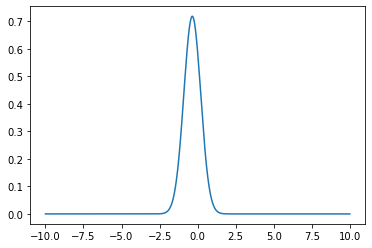

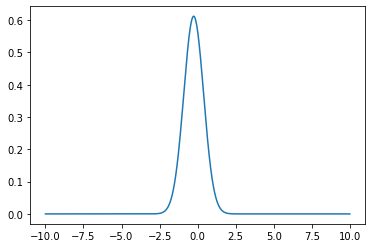

In [15]:
# study linear layer output distribution
normal_dist = lambda x, mean, var: np.exp(- np.square(x - mean) / (2 * var)) / np.sqrt(2 * np.pi * var)

def plot_normal_dist(mean, var, rmin=-10, rmax=10):
    x = np.arange(rmin, rmax, 0.01)
    y = normal_dist(x, mean, var)
    plt.plot(x, y)
    
# plain distribution
lr = LR(n_features)
data = lr.lr(x_test)
mean, var = map(float, [data.mean(), data.std() ** 2])
plot_normal_dist(mean, var)
plt.show()

# encrypted distribution
def encrypted_out_distribution(eelr, enc_x_test):
    w = eelr.weight
    b = eelr.bias
    data = []
    for enc_x in enc_x_test:
        enc_out = enc_x.dot(w) + b
        data.append(enc_out.decrypt())
    data = torch.tensor(data)
    mean, var = map(float, [data.mean(), data.std() ** 2])
    plot_normal_dist(mean, var)
    plt.show()

eelr = EncryptedLR(lr)
eelr.encrypt(ctx_training)
encrypted_out_distribution(eelr, enc_x_train)

## Encrypted Training

In [16]:
eelr = EncryptedLR(LR(n_features))
accuracy = eelr.plain_accuracy(x_test, y_test)
print(f"Accuracy at epoch #0 is {accuracy}")

times = []
for epoch in range(EPOCHS):
    eelr.encrypt(ctx_training)
    
    # if you want to keep an eye on the distribution to make sure
    # the function approxiamation is still working fine
    # WARNING: this operation is time consuming
    # encrypted_out_distribution(eelr, enc_x_train)
    
    t_start = time()
    for enc_x, enc_y in zip(enc_x_train, enc_y_train):
        enc_out = eelr.forward(enc_x)
        eelr.backward(enc_x, enc_out, enc_y)
    eelr.update_parameters()
    t_end = time()
    times.append(t_end - t_start)
    
    eelr.decrypt()
    accuracy = eelr.plain_accuracy(x_test, y_test)
    print(f"Accuracy at epoch #{epoch + 1} is {accuracy}")
    print("weight", eelr.weight)
    print("bias", eelr.bias)
    print("#################################################")


print(f"\nAverage time per epoch: {int(sum(times) / epochs)} seconds")
print(f"Final accuracy is {accuracy}")

diff_accuracy = plain_accuracy - accuracy
print(f"Difference between plain and encrypted accuracies: {diff_accuracy}")
if diff_accuracy < 0:
    print("Oh! We got a better accuracy when training on encrypted data! The noise was on our side...")

Accuracy at epoch #0 is 0.523952066898346
Accuracy at epoch #1 is 0.6766467094421387
weight [0.2133266683956842, 0.2740266179524117, 0.22401881646540636, 0.19568583534323225, 0.32442412155480027, 0.207536112882486, 0.4168974480821471, -0.03941284683125629, 0.24875166334565893]
bias [0.22382887509431498]
#################################################
Accuracy at epoch #2 is 0.703592836856842
weight [0.21103693501091975, 0.2563471811275312, 0.22485481515523914, 0.2055845012389037, 0.09617055565188562, 0.11121493315388385, 0.2167796338479159, -0.0726844240710867, 0.23081069634411425]
bias [0.15544634736648824]
#################################################
Accuracy at epoch #3 is 0.7095808386802673
weight [0.18232001662798902, 0.3636100471737133, 0.1915362636590643, 0.20199289620460448, 0.2108917290040282, 0.15685339283494493, 0.336480274733166, -0.02432413319353123, 0.22729414718667726]
bias [0.09797164530224206]
#################################################
Accuracy at epoch #

# Congratulations!!! - Time to Join the Community!

Congratulations on completing this notebook tutorial! If you enjoyed this and would like to join the movement toward privacy preserving, decentralized ownership of AI and the AI supply chain (data), you can do so in the following ways!

### Star TenSEAL on GitHub

The easiest way to help our community is just by starring the Repos! This helps raise awareness of the cool tools we're building.

- [Star TenSEAL](https://github.com/OpenMined/TenSEAL)

### Join our Slack!

The best way to keep up to date on the latest advancements is to join our community! You can do so by filling out the form at [http://slack.openmined.org](http://slack.openmined.org). #lib_tenseal and #code_tenseal are the main channels for the TenSEAL project.

### Join our Team!

If you're excited about what we are working on TenSEAL, and if you're interested to work on homomorphic encryption related use cases, you should definitely join us!

[Apply to the crypto team!](https://docs.google.com/forms/d/1T6MJ21V1lb7aEr4ilZOTYQXzxXP6KbpLumZVmTZMSuY/edit)


### Donate

If you don't have time to contribute to our codebase, but would still like to lend support, you can also become a Backer on our Open Collective. All donations go toward our web hosting and other community expenses such as hackathons and meetups!

[OpenMined's Open Collective Page](https://opencollective.com/openmined)
